data source: https://coronavirus.data.gov.uk/details/about-data#daily-and-cumulative-numbers-of-cases

downloads: https://coronavirus.data.gov.uk/details/download
using query:
https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newAdmissions&metric=newCasesByPublishDate&metric=newDeaths28DaysByDeathDate&format=csv


In [6]:
## load csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

f = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newAdmissions&metric=newCasesByPublishDate&metric=newDeaths28DaysByDeathDate&format=csv'

In [7]:
df = pd.read_csv(f, header=0, sep=',')
df['date']= df['date'].apply(pd.to_datetime)  ## date type coercion

df.head()

,areaCode,areaName,areaType,date,newAdmissions,newCasesByPublishDate,newDeaths28DaysByDeathDate
0,K02000001,United Kingdom,overview,2021-06-10,NaN,7393,NaN
1,K02000001,United Kingdom,overview,2021-06-09,NaN,7540,0.0
2,K02000001,United Kingdom,overview,2021-06-08,NaN,6048,4.0
3,K02000001,United Kingdom,overview,2021-06-07,NaN,5683,2.0
4,K02000001,United Kingdom,overview,2021-06-06,153.0,5341,6.0


In [16]:


def filterByYearAndMonth(df, year, monthStart= None, monthEnd= None):
    df1 =  df[pd.DatetimeIndex(df['date']).year == year]
    if monthStart is not None and monthEnd is not None:
        df1 = df1[pd.DatetimeIndex(df1['date']).month >= monthStart]
        df1 = df1[pd.DatetimeIndex(df1['date']).month <= monthEnd]
    elif monthStart is not None:
        df1 = df1[pd.DatetimeIndex(df1['date']).month == monthStart]
    return df1

def shiftDeathsBy(s, df):
    df1 = df.copy()
    df1['newDeaths28DaysByDeathDate'] = df['newDeaths28DaysByDeathDate'].shift(-s)   # shift "up" one column by s periods
    return df1
    
# remove  records containing nulls. this happens afer shifting: last s rows will have NaN in the shifted column
def removeNullRecords(df):
    df1 = df.dropna(subset = ['newAdmissions','newDeaths28DaysByDeathDate'])
    return df1


def plotCasesVsAdmissionsVsDeaths(df, thr=None):
    
#     ## differencing
#     df1 = df[['newAdmissions','newCasesByPublishDate','newDeaths28DaysByDeathDate']]
#     df1 = df1.diff()  ## diff by 1
#     ## take abs
#     df1['newAdmissions'] = abs(df1['newAdmissions'])
#     df1['newCasesByPublishDate'] = abs(df1['newCasesByPublishDate'])
#     df1['newDeaths28DaysByDeathDate'] = abs(df1['newDeaths28DaysByDeathDate'])
#     df1['date'] = df['date']

    ## ratios
    df['AdmissionsTocasesRatio'] = df['newAdmissions'] / df['newCasesByPublishDate']
    df['DeathsToCasesRatio'] = df['newDeaths28DaysByDeathDate'] / df['newCasesByPublishDate']
    
    
    #plot all three variables
    ax = df.plot(x='date', y='newCasesByPublishDate', legend=False)
    ax2 = ax.twinx()
    ax = df.plot(x='date', y='newAdmissions', ax=ax2, legend=False, color="r")
    ax = df.plot(x='date', y='newDeaths28DaysByDeathDate', ax=ax2, legend=False, color="c")
    ax.figure.legend()
    plt.show()
  
    ## plot the straight ratio cases / admissions and cases / deaths
    
    
    # plot the ratios
    ax1 = df.plot(x='date', y='AdmissionsTocasesRatio', legend=False, color="r")
    ax2 = df.plot(x='date', y='DeathsToCasesRatio', legend=False, color="c")
    ax1.figure.legend()
    ax2.figure.legend()
    plt.show()

    
    df_clipped = df
    if thr != None:
        df_clipped = df[df['newCasesByPublishDate'] < thr]
    
    plt.scatter(df_clipped['newCasesByPublishDate'], df_clipped['newAdmissions'])
    plt.xlabel('newCasesByPublishDate')
    plt.ylabel('newAdmissions')
    plt.show()
    
    plt.scatter(df_clipped['newCasesByPublishDate'], df_clipped['newDeaths28DaysByDeathDate'])
    plt.xlabel('newCasesByPublishDate')
    plt.ylabel('newDeaths28DaysByDeathDate')
    plt.show()
    
    print("Pearson's correlations:")
    print("newCasesByPublishDate vs newAdmissions: \t\t{corr}".format(corr=df['newCasesByPublishDate'].corr(df['newAdmissions'])))
    print("newCasesByPublishDate vs newDeaths28DaysByDeathDate: \t{corr}".format(corr=df['newCasesByPublishDate'].corr(df['newDeaths28DaysByDeathDate'])))
    
    
def summaryStats(df):
    print("\n\n** summary stats **")

    print("newCasesByPublishDate:")
    print(df['newCasesByPublishDate'].describe(), '\n')

    print("newAdmissions:")
    print(df['newAdmissions'].describe(), '\n')

    print("newDeaths28DaysByDeathDate:")
    print(df['newDeaths28DaysByDeathDate'].describe(), '\n')
 
def shiftCalibrate(df):
    corr = {}
    max = 0
    NMax = 20
    for N in range(20,80):
        df1 = shiftDeathsBy(N,df)
        dfClean = removeNullRecords(df1)
        corr[N] = df['newCasesByPublishDate'].corr(dfClean['newDeaths28DaysByDeathDate'])
        if corr[N] > max:
            max = corr[N]
            NMax= N
    s = pd.Series(corr)
    return s, NMax, max

year 2020: correlation max is 0.1792792731201117 at N=20
year 2020 1-7: correlation max is 0.6208309532650954 at N=20
year 2020 8-12: correlation max is 0.7834441708944285 at N=79
year 2021: correlation max is 0.7949052715108323 at N=24


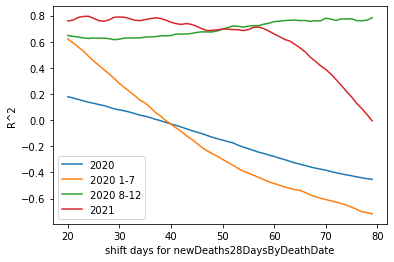

In [9]:
## calibrate time shift for deaths as these are delayed by about 30 days
# this is done by maximising the correlation (R^2) on the 2020 fraction

year1 = 2020
df2020 = filterByYearAndMonth(df, year1)
s, N2020, NMax2020 = shiftCalibrate(df2020)
print("year {y}: correlation max is {c} at N={n}".format(y=year1, c=NMax2020, n=N2020))
ax = s.plot()
    
## check also first half of 2020 only
df2020_1 = filterByYearAndMonth(df, 2020, 1,7)
s, N2020_1, NMax2020_1 = shiftCalibrate(df2020_1)
print("year {y}: correlation max is {c} at N={n}".format(y="2020 1-7", c=NMax2020_1, n=N2020_1))
ax = s.plot()

## check also second half of 2020 only
df2020_2 = filterByYearAndMonth(df, 2020, 8,12)
s, N2020_2, NMax2020_2 = shiftCalibrate(df2020_2)
print("year {y}: correlation max is {c} at N={n}".format(y="2020 8-12", c=NMax2020_2, n=N2020_2))
ax = s.plot()

year2 = 2021
df2021 = filterByYearAndMonth(df, year2)
s, N2021, NMax2021 = shiftCalibrate(df2021)
print("year {y}: correlation max is {c} at N={n}".format(y=year2, c=NMax2021, n=N2021))
ax = s.plot(xlabel='shift days for newDeaths28DaysByDeathDate', ylabel='R^2')

ax.legend([str(year1), str(year1)+" 1-7", str(year1)+" 8-12", str(year2)])

based on the analysis above, and on the standard "death recorded 28 days after testing positive" rule, we are going to timeshift at N=30 for all time slices
because of the shifting, we only consider slices of at least two months 

time plots and scatter plots with correlation scores (pearson R^2) for different time periods

plot entire timeline 

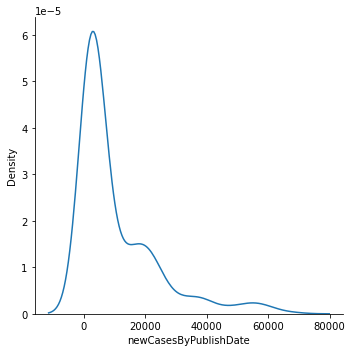

In [10]:
df1 = removeNullRecords(shiftDeathsBy(30, df))

## distribution of new cases -- used to decide on a threshold for correlation analysis
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

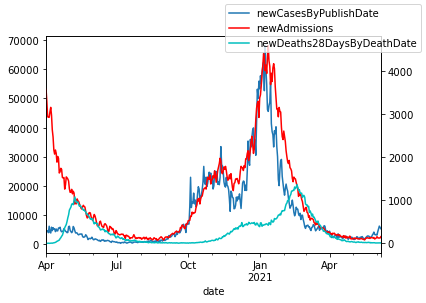

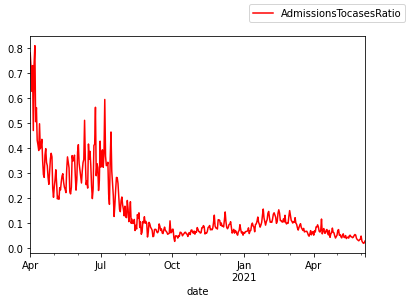

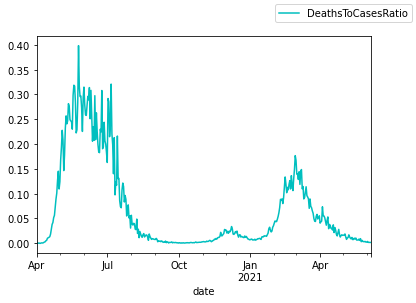

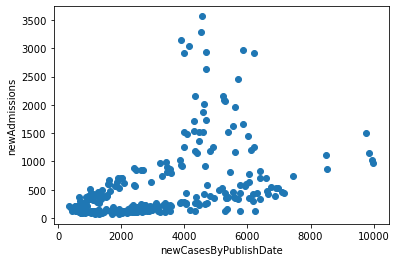

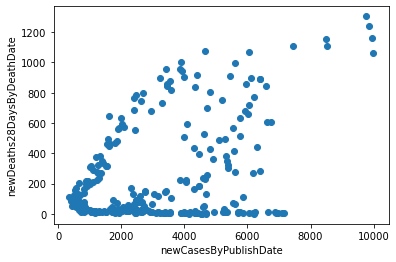

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.8383193385530479
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.21778907152658727


** summary stats **
newCasesByPublishDate:
count      432.000000
mean     10508.328704
std      13269.209773
min        343.000000
25%       1944.500000
50%       4500.500000
75%      15908.750000
max      68053.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     432.000000
mean     1028.138889
std      1064.465586
min        72.000000
25%       176.750000
50%       583.000000
75%      1540.250000
max      4578.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count     432.000000
mean      295.474537
std       336.770350
min         0.000000
25%        23.750000
50%       138.500000
75%       464.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



In [17]:
## based on density plot, zoom in 0-10000 cases

# line and scatter plots
plotCasesVsAdmissionsVsDeaths(df1, thr=10000)

summaryStats(df1)

### plot all of 2020

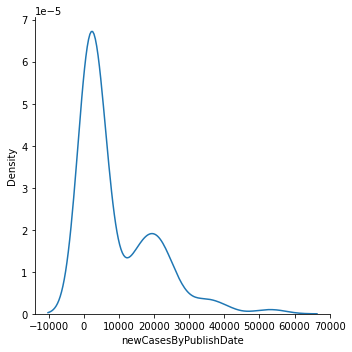

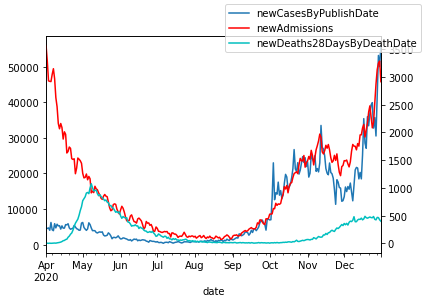

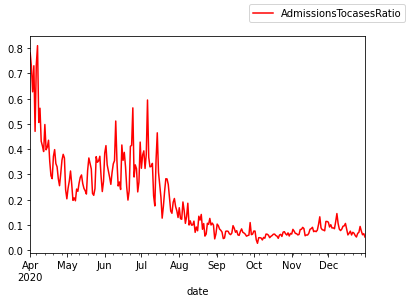

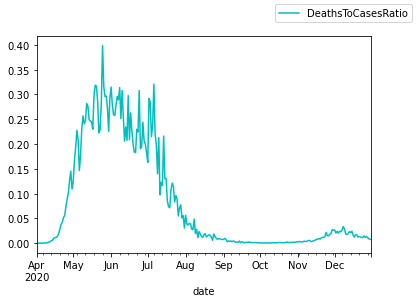

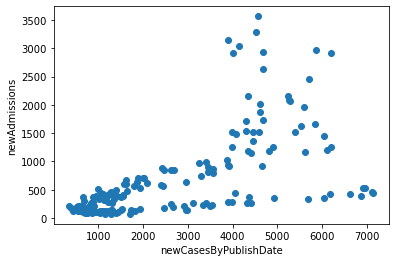

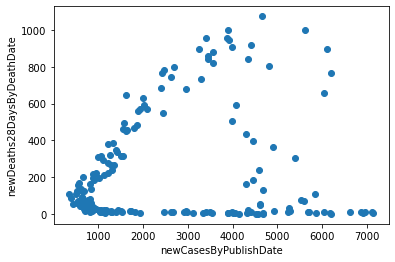

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.6787067780042647
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.07801465232256373


** summary stats **
newCasesByPublishDate:
count      275.000000
mean      9072.774545
std      10755.407063
min        343.000000
25%       1211.500000
50%       4044.000000
75%      16170.500000
max      55892.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     275.000000
mean      961.505455
std       826.275516
min        72.000000
25%       214.000000
50%       711.000000
75%      1526.000000
max      3565.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count     275.000000
mean      221.054545
std       261.649792
min         0.000000
25%        16.500000
50%        90.000000
75%       381.000000
max      1075.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



In [18]:
df1 = filterByYearAndMonth(df, 2020)
df1 = shiftDeathsBy(30, df1)
df1 = removeNullRecords(df1)

## distribution of new cases -- used to decide on a threshold for correlation analysis
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

plotCasesVsAdmissionsVsDeaths(df1, thr=10000)

summaryStats(df1)

### plot second half of 2020

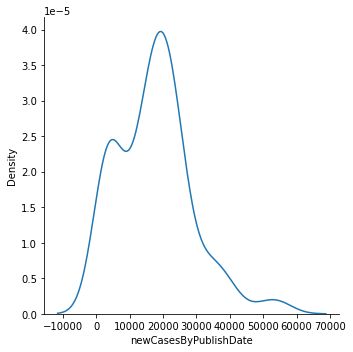

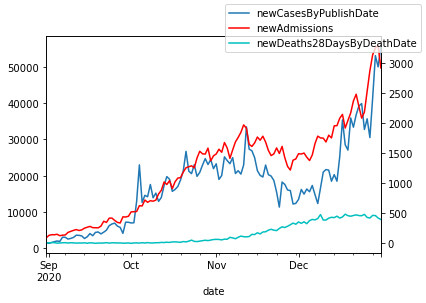

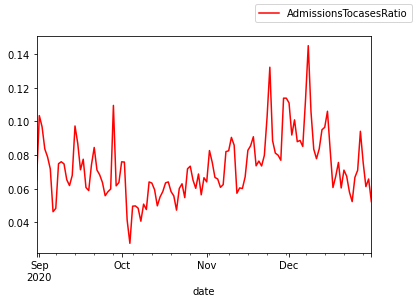

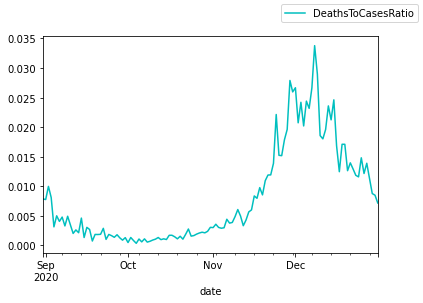

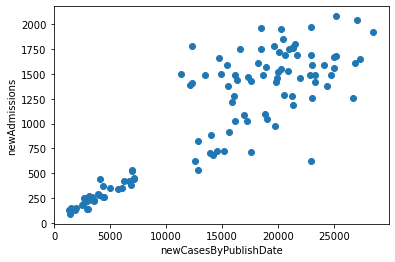

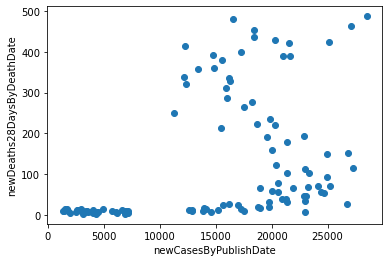

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.9139021214012862
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.6196861263464872


** summary stats **
newCasesByPublishDate:
count      123.000000
mean     17525.528455
std      11211.001732
min       1295.000000
25%       7038.000000
50%      17555.000000
75%      22955.500000
max      55892.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     123.000000
mean     1238.991870
std       758.542298
min        91.000000
25%       488.500000
50%      1414.000000
75%      1686.500000
max      3286.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count    123.000000
mean     157.991870
std      174.771068
min        3.000000
25%       12.000000
50%       60.000000
75%      332.000000
max      487.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



In [19]:
df1 = filterByYearAndMonth(df, 2020, 8,12)
df1 = shiftDeathsBy(30, df1)
df1 = removeNullRecords(df1)

## distribution of new cases -- used to decide on a threshold for correlation analysis
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

plotCasesVsAdmissionsVsDeaths(df1, thr=30000)
summaryStats(df1)

### plot all of 2021

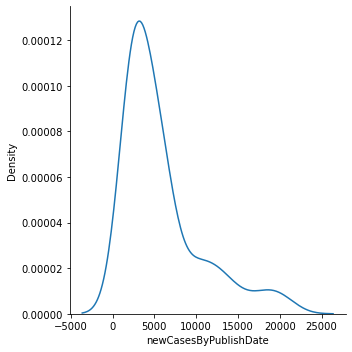

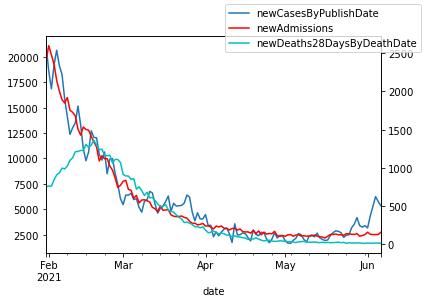

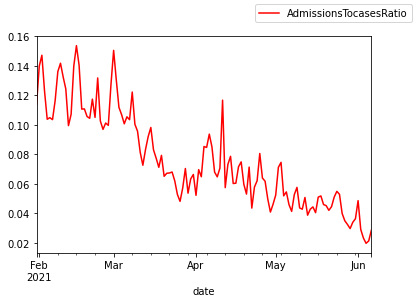

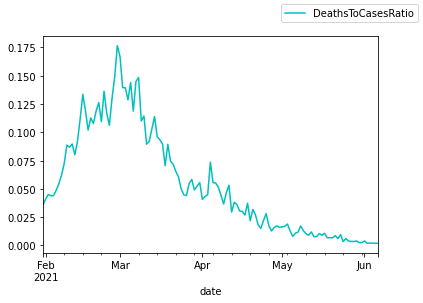

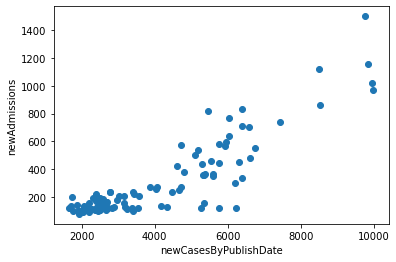

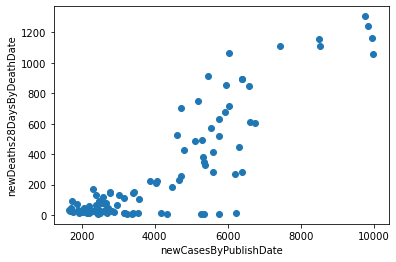

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.9670420195168363
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.789241222056304


** summary stats **
newCasesByPublishDate:
count      127.000000
mean      5805.283465
std       4642.060976
min       1649.000000
25%       2492.000000
50%       4182.000000
75%       6394.000000
max      21088.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     127.000000
mean      543.944882
std       624.906143
min        78.000000
25%       124.500000
50%       234.000000
75%       708.500000
max      2600.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count     127.000000
mean      403.488189
std       448.045719
min         8.000000
25%        28.000000
50%       153.000000
75%       758.500000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



In [20]:
df1 = filterByYearAndMonth(df, 2021)
df1 = shiftDeathsBy(30, df1)
df1 = removeNullRecords(df1)

## distribution of new cases -- used to decide on a threshold for correlation analysis
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

plotCasesVsAdmissionsVsDeaths(df1, thr=10000)

summaryStats(df1)

# df1

### zoom in 1-4 2021

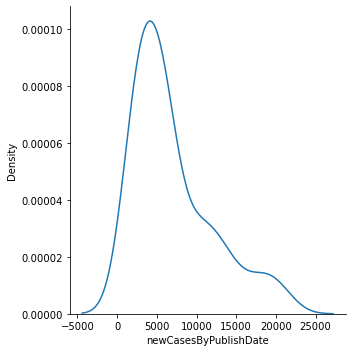

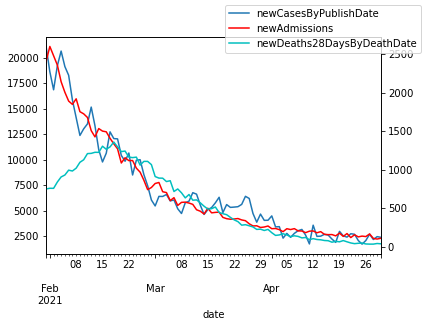

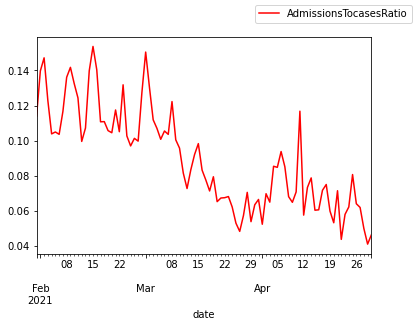

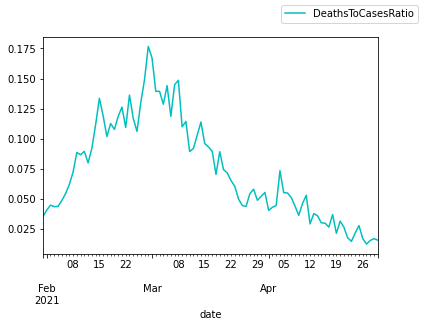

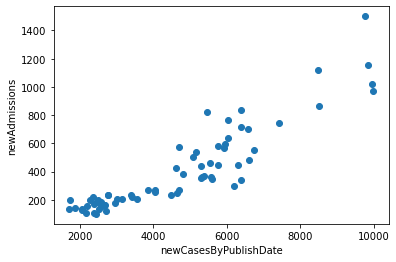

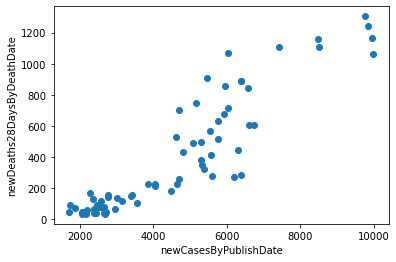

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.9705330533696025
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.7527293949280343


** summary stats **
newCasesByPublishDate:
count       90.000000
mean      6993.633333
std       5005.827172
min       1712.000000
25%       2813.000000
50%       5494.500000
75%       9912.000000
max      21088.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count      90.000000
mean      719.733333
std       667.451413
min       100.000000
25%       205.250000
50%       443.000000
75%      1110.250000
max      2600.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count      90.000000
mean      561.788889
std       444.069776
min        34.000000
25%       131.750000
50%       491.500000
75%       970.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



In [21]:
df1 = filterByYearAndMonth(df, 2021, 1,4)
df1 = shiftDeathsBy(30, df1)
df1 = removeNullRecords(df1)

## distribution of new cases -- used to decide on a threshold for correlation analysis
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

plotCasesVsAdmissionsVsDeaths(df1, thr=10000)
summaryStats(df1)

### zoom in 3-6 2021 only

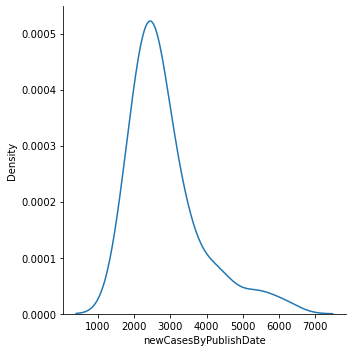

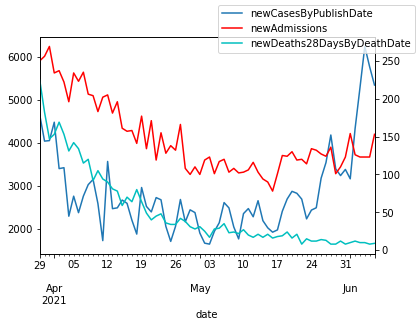

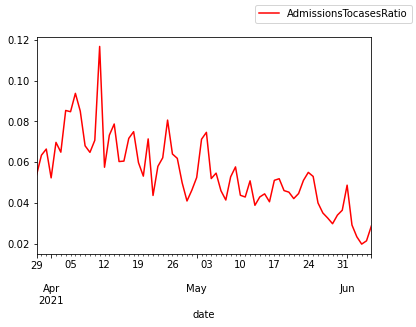

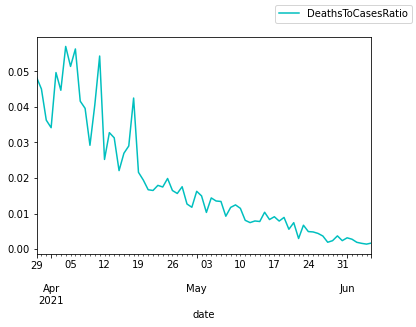

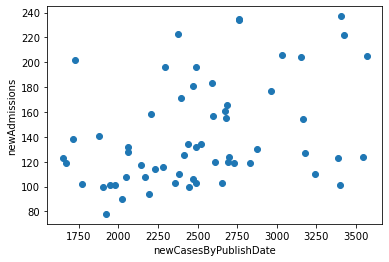

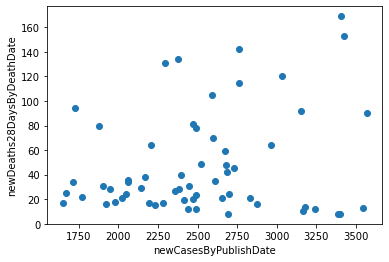

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.2922891156790804
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.1502595865667051


** summary stats **
newCasesByPublishDate:
count      70.000000
mean     2846.928571
std       979.990141
min      1649.000000
25%      2213.250000
50%      2592.500000
75%      3176.250000
max      6238.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     70.000000
mean     147.042857
std       47.106243
min       78.000000
25%      114.500000
50%      127.500000
75%      175.500000
max      269.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count     70.000000
mean      51.614286
std       50.944497
min        8.000000
25%       16.250000
50%       28.500000
75%       76.000000
max      225.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



In [22]:
df1 = filterByYearAndMonth(df, 2021, 3,6)
df1 = shiftDeathsBy(28, df1)
df1 = removeNullRecords(df1)

## distribution of new cases -- used to decide on a threshold for correlation analysis
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

plotCasesVsAdmissionsVsDeaths(df1, thr=4000)
summaryStats(df1)